# Lac Pavin rubisco

In [12]:
import os, glob, random
import pandas as pd
import numpy as np
import subprocess as sp
import seaborn as sns
from Bio import SeqIO, SearchIO
import matplotlib.pyplot as plt
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor

In [13]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

def encode(path):
    return "A" + "".join(os.path.basename(path).split("_")[1:3])      

In [14]:
def categorize(sample_name):
    
    if "SED" in sample_name:
        return "sediment"
    elif "12" in sample_name:
        return "shallow"
    elif "70" in sample_name or "90" in sample_name:
        return "anoxic zone"
    else: return "interface"

In [15]:
rootdir = "/groups/banfield/projects/environmental/LacPavin/analysis/"

### hmm searches

In [27]:
cmdir(rootdir + "metabolism/rubisco")
cmdir(rootdir + "metabolism/rubisco/hmm_results")

In [16]:
# define samples/assemblies of interest
assemblies = {"water_column":[], "sediment":[]}
for assembly in glob.glob(rootdir.replace("analysis/", "QB3*/assembly.d/*/*megahit*/*min1000.fa")):
    if ("Creux" not in assembly) and ("ALN" not in assembly) and ("70S" not in assembly):
        if "SED" in assembly:
            assemblies["sediment"].append(assembly)
        else: assemblies["water_column"].append(assembly)

In [51]:
hmm_dir = "/groups/banfield/users/ajaffe/cpr-dpann/nr-set-complete/" + \
            "metabolism/hmms/by-source/NCOMMS_custom/"

for biome in assemblies:
    for assembly in assemblies[biome]:
        protein_file = assembly + ".genes.faa"
        for hmm in glob.glob(hmm_dir + "rubisco*"):
            search_name = encode(assembly) + "_vs_" + os.path.basename(hmm).split(".")[0]
            call = "hmmsearch --cpu 20 --tblout %s %s %s" %(rootdir + "metabolism/rubisco/hmm_results/" + \
                search_name + ".results", hmm, protein_file)
            sp.call(call, shell=True)

In [17]:
def parse_hmm(result_table):
    
    temp = {}
    count = 0
    
    # parse each result file using searchio
    for result in SearchIO.parse(result_table, "hmmer3-tab"):
        for item in result.hits:
            temp[count] = {"gene": item.id, "score": item.bitscore, "eval": item.evalue}
            count += 1
            
    return(pd.DataFrame.from_dict(temp, orient="index"))

In [18]:
hmm_results = []

for hmm_result in glob.glob(rootdir + "metabolism/rubisco/hmm_results/*"):
    
    table = parse_hmm(hmm_result)
    table["sample"] = os.path.basename(hmm_result).split("_vs_")[0]
    table["hmm"] = os.path.basename(hmm_result).split("_vs_")[1].replace(".results", "")
    hmm_results.append(table)
    
rubisco_results = pd.concat(hmm_results)
# add in cutoffs
rubisco_results.head()

,gene,score,eval,sample,hmm
0,LacPavin_0419_WC90_scaffold_983577_2,350.9,3.500000e-103,A0419WC90,rubisco_form_I
1,LacPavin_0419_WC90_scaffold_192434_2,347.2,4.700000e-102,A0419WC90,rubisco_form_I
2,LacPavin_0419_WC90_scaffold_379275_127,309.4,1.400000e-90,A0419WC90,rubisco_form_I
3,LacPavin_0419_WC90_scaffold_544601_1,307.8,4.000000e-90,A0419WC90,rubisco_form_I
4,LacPavin_0419_WC90_scaffold_647009_4,303.5,8.300000e-89,A0419WC90,rubisco_form_I


In [7]:
# read in cutoffs
cutoffs = pd.read_csv("/groups/banfield/users/ajaffe/cpr-dpann/nr-set-complete/metabolism/hmms/cpr_metabolism_table - hmm_subset.tsv", sep="\t")
results_merged = rubisco_results.merge(cutoffs[["hmm_name", "published_cutoff"]], how="left", left_on="hmm", right_on="hmm_name")
results_merged.head()

,gene,score,eval,sample,hmm,hmm_name,published_cutoff
0,LacPavin_0419_WC90_scaffold_983577_2,350.9,3.500000e-103,A0419WC90,rubisco_form_I,rubisco_form_I,500.0
1,LacPavin_0419_WC90_scaffold_192434_2,347.2,4.700000e-102,A0419WC90,rubisco_form_I,rubisco_form_I,500.0
2,LacPavin_0419_WC90_scaffold_379275_127,309.4,1.400000e-90,A0419WC90,rubisco_form_I,rubisco_form_I,500.0
3,LacPavin_0419_WC90_scaffold_544601_1,307.8,4.000000e-90,A0419WC90,rubisco_form_I,rubisco_form_I,500.0
4,LacPavin_0419_WC90_scaffold_647009_4,303.5,8.300000e-89,A0419WC90,rubisco_form_I,rubisco_form_I,500.0


In [19]:
# filter 
filtered_results = results_merged[results_merged["score"]>=results_merged["published_cutoff"]].sort_values("score", ascending=False).drop_duplicates("gene")
filtered_results["hmm"].value_counts()

rubisco_form_I         156
rubisco_form_III       102
rubisco_form_II         36
rubisco_form_II_III     15
Name: hmm, dtype: int64

### de-replicate across samples

In [121]:
cmdir(rootdir + "metabolism/rubisco/scaffolds")

In [20]:
filtered_results["scaffold"] = filtered_results["gene"].apply(lambda x: "_".join(x.split("_")[:-1]))
filtered_results["sample"] = filtered_results["gene"].apply(lambda x: "_".join(x.split("_")[0:3]))

In [14]:
for sample in filtered_results["sample"].unique():
    
    # find assembly
    biome = "sediment" if "SED" in sample else "water_column"
    for assembly in assemblies[biome]:
        if sample in assembly:
            path = assembly
    
    # get assembly
    tmp = {}
    for record in SeqIO.parse(open(path), "fasta"):
        tmp[record.description.split(" ")[0]] = str(record.seq)
            
    scaffolds = list(filtered_results[filtered_results["sample"]==sample]["scaffold"].unique())
    
    for scaffold in scaffolds:
        with open(rootdir + "metabolism/rubisco/scaffolds/" + scaffold + ".fna", "w") as out:
             out.write(">%s\n%s\n" %(scaffold, tmp[scaffold]))

tmp = []

In [145]:
call = "dRep cluster -g %s -p 20 -pa 0.80 -sa 0.95 --clusterAlg single %s" %(rootdir + \
    "metabolism/rubisco/scaffolds/*", rootdir + "metabolism/rubisco/drep")
#print(call)
call2 = "dRep analyze %s -pl 2" %(rootdir + "metabolism/rubisco/drep")
print(call2)

dRep analyze /groups/banfield/projects/environmental/LacPavin/analysis/metabolism/rubisco/drep -pl 2


In [21]:
# build scaf2bin
scaf2bin = {}

for genome in glob.glob(rootdir + "genomes/renamed_genomes/*"):
    name = os.path.basename(genome).replace(".fna", "")
    for record in SeqIO.parse(open(genome), "fasta"):
        scaf2bin[record.description.split(" ")[0]] = name
        
# get scaf lens
scaflens = {}
for scaffold in glob.glob(rootdir + "metabolism/rubisco/scaffolds/*"):
    for record in SeqIO.parse(open(scaffold), "fasta"):
        scaflens[record.description] = len(record.seq)

In [22]:
# choose representatives
rclust = pd.read_csv(rootdir + "metabolism/rubisco/drep/data_tables/Cdb.csv")
rclust["scaffold"] = rclust["genome"].apply(lambda x: x.split(".")[0])
rclust["binned"] = rclust["scaffold"].apply(lambda x: x in scaf2bin.keys())
rclust["scaffold_length"] = rclust["scaffold"].map(scaflens)
# prioritize binned ones, then by length
rsub = rclust.sort_values(["binned", "scaffold_length"], ascending=[False, False]).drop_duplicates("secondary_cluster")
# implement size min
rsub = rsub.query("scaffold_length>=5000")
rsub.head()

,genome,secondary_cluster,threshold,cluster_method,comparison_algorithm,primary_cluster,scaffold,binned,scaffold_length
137,LacPavin_0920_WC70_scaffold_73101.fna,53_2,0.05,single,ANImf,53,LacPavin_0920_WC70_scaffold_73101,True,351945
39,LacPavin_0920_SED3_scaffold_3163924.fna,24_0,0.05,single,ANImf,24,LacPavin_0920_SED3_scaffold_3163924,True,231741
111,LacPavin_0818_WC45_scaffold_603032.fna,50_2,0.05,single,ANImf,50,LacPavin_0818_WC45_scaffold_603032,True,208386
290,LacPavin_0920_WC70_scaffold_395088.fna,74_0,0.05,single,ANImf,74,LacPavin_0920_WC70_scaffold_395088,True,175918
285,LacPavin_0818_WC50_scaffold_858530.fna,69_0,0.05,single,ANImf,69,LacPavin_0818_WC50_scaffold_858530,True,155562


In [209]:
# write out final set
with open(rootdir + "metabolism/rubisco/rubisco_scaffold_subset.fna", "w") as out:
    for key, row in rsub.iterrows():
        for record in SeqIO.parse(open(rootdir + "metabolism/rubisco/scaffolds/" + row["genome"]), "fasta"):
            out.write(">%s\n%s\n" %(record.description, str(record.seq)))

### remap reads

In [164]:
cmdir(rootdir + "metabolism/rubisco/mapping")

In [210]:
# gather read files
reads = {"water_column":[], "sediment":[]}

# project dir
for sample in glob.glob(rootdir.replace("analysis/", "QB3*/raw.d/*/")):
    if (("Creux" not in sample) and ("07_03" not in sample)):
        fwd = glob.glob(sample + "/*.PE.1.fastq.gz")[0]
        rev = glob.glob(sample + "/*.PE.2.fastq.gz")[0]
        reads["water_column"].append((fwd,rev))

# /banfield/sequences
for sample in glob.glob("/groups/banfield/sequences/2020/LacPavin*/"):
    if "ALN" not in sample:
        fwd = glob.glob(sample + "raw.d/*.PE.1.fastq.gz")[0]
        rev = glob.glob(sample + "raw.d/*.PE.2.fastq.gz")[0]
        if "SED" in sample:
            reads["sediment"].append((fwd, rev))
        else: reads["water_column"].append((fwd, rev))

In [211]:
#remap reads from all samples
with open(rootdir + "/metabolism/rubisco/remap.sh","w") as outfile:
    
    #build bt index
    call = "/shared/software/bin/bowtie2-build " + rootdir + "/metabolism/rubisco/rubisco_scaffold_subset.fna " + \
        rootdir + "metabolism/rubisco/mapping/rubisco_scaffold_subset.fna"
    outfile.write(call + "\n")

    for biome in reads:
        
        for read_tuple in reads[biome]:
            
            if "70S" not in read_tuple[0]:
                # read shorthand
                rcode = "R" + "".join(os.path.basename(read_tuple[0]).split("_")[1:3])
                filecode = rootdir + "/metabolism/rubisco/mapping/scaffolds_" + rcode
                # generate mapping
                mapping = "/shared/software/bin/bowtie2 -p \$SLURM_CPUS_ON_NODE -x " + rootdir + "/metabolism/rubisco/mapping/rubisco_scaffold_subset.fna -1 " + \
                    read_tuple[0] + " -2 " + read_tuple[1] + " 2> " + filecode + ".log" + \
                    " | /shared/software/bin/shrinksam | /shared/software/bin/samtools view -S -b > " + filecode + ".bam"
                outfile.write(mapping + "\n")
                # generate sorted bam + idx
                sort = "/shared/software/bin/samtools sort --threads \$SLURM_CPUS_ON_NODE " + filecode + ".bam > " + filecode + ".sorted.bam"
                index = "/shared/software/bin/samtools index -@ \$SLURM_CPUS_ON_NODE " + filecode + ".sorted.bam"
                outfile.write(sort + "\n" + index + "\n")  

In [168]:
coverm = "coverm contig --min-read-percent-identity 0.95 --min-covered-fraction 0 --output-format sparse -b " + \
        rootdir + "/metabolism/rubisco/mapping/*sorted.bam -m count mean covered_fraction length> " + \
        rootdir + "/metabolism/rubisco/coverage_table.95.csv"
print(coverm)

coverm contig --min-read-percent-identity 0.95 --min-covered-fraction 0 --output-format sparse -b /groups/banfield/projects/environmental/LacPavin/analysis//metabolism/rubisco/mapping/*sorted.bam -m count mean covered_fraction length> /groups/banfield/projects/environmental/LacPavin/analysis//metabolism/rubisco/coverage_table.95.csv


In [23]:
# read in and compute perc coverage by sample
coverage_table = pd.read_csv(rootdir + "/metabolism/rubisco/coverage_table.95.csv", sep="\t")
coverage_table = coverage_table[coverage_table["Covered Fraction"] >= 0.50]
coverage_table.head()

,Sample,Contig,Read Count,Mean,Covered Fraction,Length
16,scaffolds_R0419WC53.sorted,LacPavin_0818_WC45_scaffold_2432,1587,4.008360,0.971051,55892
20,scaffolds_R0419WC53.sorted,LacPavin_0419_WC53_scaffold_176139,1820,6.032580,0.999256,43029
36,scaffolds_R0419WC53.sorted,LacPavin_0920_WC12_scaffold_731800,173,1.809838,0.652062,13649
38,scaffolds_R0419WC53.sorted,LacPavin_0818_WC50_scaffold_193852,152,1.892142,0.877835,11730
39,scaffolds_R0419WC53.sorted,LacPavin_0920_WC12_scaffold_146098,104,1.348366,0.664659,10461


### assign taxonomy

In [24]:
metadata = filtered_results[["gene", "scaffold", "hmm"]]
# only representatives
metadata = metadata[metadata["scaffold"].isin(rsub["scaffold"])]
metadata.head()

,gene,scaffold,hmm
5967,LacPavin_0419_WC53_scaffold_176139_17,LacPavin_0419_WC53_scaffold_176139,rubisco_form_I
3893,LacPavin_0920_WC70_scaffold_73101_221,LacPavin_0920_WC70_scaffold_73101,rubisco_form_I
6186,LacPavin_0920_WC90_scaffold_373145_83,LacPavin_0920_WC90_scaffold_373145,rubisco_form_I
3165,LacPavin_0920_WC12_scaffold_364754_8,LacPavin_0920_WC12_scaffold_364754,rubisco_form_I
3894,LacPavin_0920_WC70_scaffold_1243547_9,LacPavin_0920_WC70_scaffold_1243547,rubisco_form_I


In [25]:
corrections = {"LacPavin_0920_SED2_scaffold_1836805": "Eukaryota",
               "LacPavin_0920_SED4_scaffold_978375": "Actinobacteria",
               "LacPavin_0920_SED3_scaffold_2676896": "Micrarchaeota",
               "LacPavin_0920_SED5_scaffold_2191406": "Pacearchaeota",
               "LacPavin_0920_SED5_scaffold_2358586": "Pacearchaeota",
               "LacPavin_0818_WC55_scaffold_121014": "Absconditabacteria",
               "LacPavin_0818_WC45_scaffold_408317": "Absconditabacteria",
               "LacPavin_0818_WC45_scaffold_84891": "Absconditabacteria",
               "LacPavin_0818_WC55_scaffold_186018": "Komeilibacteria",
               "LacPavin_0920_SED3_scaffold_1657037": "Pacearchaeota",
               "LacPavin_0920_SED1_scaffold_1402580": "Diapherotrites",
               "LacPavin_0920_SED5_scaffold_98855": "Woesearchaeota",
               "LacPavin_0920_SED4_scaffold_2970434": "Pacearchaeota",
               "LacPavin_0920_SED4_scaffold_2653163": "Woesearchaeota",
               "LacPavin_0920_SED3_scaffold_3163924": "Aenigmarchaeota",
               "LacPavin_0920_SED5_scaffold_2130264": "Bathyarchaeota",
               "LacPavin_0920_SED4_scaffold_2546189": "Micrarchaeota",
               "LacPavin_0920_SED5_scaffold_1455081": "Woesearchaeota",
               "LacPavin_0920_SED3_scaffold_1745283": "Pacearchaeota",
               "LacPavin_0920_SED5_scaffold_2623920": "Pacearchaeota",
               "LacPavin_0920_SED2_scaffold_1447234": "Pacearchaeota",
               "LacPavin_0920_SED3_scaffold_3489162": "Aenigmarchaeota",
               "LacPavin_0920_SED5_scaffold_655205": "Aenigmarchaeota",
               "LacPavin_0920_SED3_scaffold_2583291": "unknown",
               "LacPavin_0920_SED3_scaffold_3551243": "Pacearchaeota",
               "LacPavin_0818_WC50_scaffold_193852": "Cyanobacteria",
               "LacPavin_0920_SED3_scaffold_2299760": "Micrarchaeota",
               "LacPavin_0920_SED3_scaffold_252231": "Diapherotrites",
               "LacPavin_0419_WC90_scaffold_379275": "Komeilibacteria",
               "LacPavin_0920_SED5_scaffold_3007034": "Micrarchaeota",
               "LacPavin_0920_WC12_scaffold_49252": "Eukaryota",
               "LacPavin_0920_SED3_scaffold_30927": "Pacearchaeota",
               "LacPavin_0920_SED3_scaffold_930715": "Micrarchaeota"}

In [26]:
# read in contig taxonomy
contig_taxonomy = pd.concat([pd.read_csv(item, sep="\t") for item in glob.glob(rootdir + "ggkbase/*.contig-taxonomy*.tsv")])
contig_sub = contig_taxonomy[contig_taxonomy["Phylum winner %"]>=0.50]
metadata = metadata.merge(contig_sub[["Contig name", "Phylum winner"]], how="left", left_on="scaffold", right_on="Contig name").drop("Contig name", axis=1).fillna("None")
metadata = metadata.rename(columns={"Phylum winner": "contig_taxonomy"})
metadata["bin"] = metadata["scaffold"].map(scaf2bin)
metadata["revised_taxonomy"] = metadata.apply(lambda x: x["contig_taxonomy"] if x["scaffold"] not in corrections.keys() else corrections[x["scaffold"]] , axis=1)
metadata.head()

,gene,scaffold,hmm,contig_taxonomy,bin,revised_taxonomy
0,LacPavin_0419_WC53_scaffold_176139_17,LacPavin_0419_WC53_scaffold_176139,rubisco_form_I,Proteobacteria,LacPavin_0419_WC53_Rhizobiales_62_6,Proteobacteria
1,LacPavin_0920_WC70_scaffold_73101_221,LacPavin_0920_WC70_scaffold_73101,rubisco_form_I,Proteobacteria,LacPavin_0920_WC70_Gammaproteobacteria_66_37,Proteobacteria
2,LacPavin_0920_WC90_scaffold_373145_83,LacPavin_0920_WC90_scaffold_373145,rubisco_form_I,Proteobacteria,LacPavin_0920_WC90_Mesorhizobium_64_12,Proteobacteria
3,LacPavin_0920_WC12_scaffold_364754_8,LacPavin_0920_WC12_scaffold_364754,rubisco_form_I,Proteobacteria,NaN,Proteobacteria
4,LacPavin_0920_WC70_scaffold_1243547_9,LacPavin_0920_WC70_scaffold_1243547,rubisco_form_I,Proteobacteria,LacPavin_0920_WC70_Gammaproteobacteria_68_44,Proteobacteria


In [27]:
# then drop eukaryotes
metadata = metadata[~metadata["revised_taxonomy"].isin(["Eukaryota", "Chlorophyta", "Bacillariophyta"])]
metadata["revised_taxonomy"].value_counts()

Proteobacteria        26
Cyanobacteria         12
Pacearchaeota          9
Micrarchaeota          5
Euryarchaeota          5
Bathyarchaeota         5
Absconditabacteria     3
Woesearchaeota         3
Aenigmarchaeota        3
Actinobacteria         2
Komeilibacteria        2
Diapherotrites         2
unknown                1
Name: revised_taxonomy, dtype: int64

### confirm rubisco form

In [239]:
cmdir(rootdir + "metabolism/rubisco/tree")

In [263]:
# write out LP sequences
metadata["sample"] = metadata["gene"].apply(lambda x: "_".join(x.split("_")[0:3]))
protein_file = open(rootdir + "metabolism/rubisco/rubisco_protein_subset.faa", "w")

for sample in metadata["sample"].unique():
    
    # find assembly
    biome = "sediment" if "SED" in sample else "water_column"
    for assembly in assemblies[biome]:
        if sample in assembly:
            path = assembly + ".genes.faa"
    
    # get proteins
    tmp = {}
    for record in SeqIO.parse(open(path), "fasta"):
        tmp[record.description.split(" ")[0]] = str(record.seq)
            
    genes = list(metadata[metadata["sample"]==sample]["gene"].unique())
    
    for gene in genes:
        protein_file.write(">%s\n%s\n" %(gene, tmp[gene]))

tmp = []
protein_file.close()

In [19]:
# prep reference sequences
ref_data = defaultdict(list)

for record in SeqIO.parse(open(rootdir + "metabolism/rubisco/tree/unmasked_rubisco_aln copy.txt"), "fasta"):
    
    ref_data["name"].append(record.description.split(":")[0])
    ref_data["tax"].append(record.description.split(":")[1])
    ref_data["form"].append(record.description.split(":")[2])
    ref_data["seq"].append(str(record.seq).replace("-",""))

ref_df = pd.DataFrame(ref_data)

In [262]:
# downsample
with open(rootdir + "metabolism/rubisco/tree/references.faa", "w") as out:
    
    for form in ref_df["form"].unique():
        if form != "unknown":
            table = ref_df[ref_df["form"]==form]
            sample = random.sample(table["name"].to_list(), min(len(table),50))
            subtable = table[table["name"].isin(sample)]
            for key, row in subtable.iterrows():
                out.write(">%s\n%s\n" %(row["name"], row["seq"]))        

Concat with LP manually, run mafft, trimal, tree in shell.

In [277]:
color_dict = {"I": "#a6d6a6", "II": "#e2b2ac", "II/III": "#e0635a",
             "III-a": "#ea8b18", "III-b": "#edb66e", "III-c": "#eacfb0",
              "III-like": "#e5dc6c", "IV": "#c798c5", "IV-like": "#c654c6", "III": "#c6c6c6"}

In [326]:
# annotate tree
with open(rootdir + "metabolism/rubisco/tree/rubisco.itol.txt", "w") as itol:
    itol.write("TREE_COLORS\nSEPARATOR TAB\nDATA\n")
    for key, row in ref_df.iterrows():
        if row["form"] != "unknown":
            itol.write(row["name"] + "\trange\t" + color_dict[row["form"]] + "\t" + row["form"] + "\n")
    for key, row in metadata.iterrows():
        form = row["hmm"].split("_form_")[1].replace("_", "/")
        if form == "III":
            form = "III-b"
        itol.write(row["gene"] + "\trange\t" + color_dict[form] + "\t" + form + "\n")

In [28]:
# correct form assignments
revised_forms = {"LacPavin_0920_SED4_scaffold_1921928_21": "III-a",
                "LacPavin_0419_WC90_scaffold_379275_127": "III-c"}

metadata["revised_form"] = metadata.apply(lambda x: x["hmm"].split("_form_")[1].replace("_", "/") if x["gene"] not in revised_forms.keys() else revised_forms[x["gene"]], axis=1)
metadata = metadata.replace("III", "III-b")
metadata.head()

,gene,scaffold,hmm,contig_taxonomy,bin,revised_taxonomy,revised_form
0,LacPavin_0419_WC53_scaffold_176139_17,LacPavin_0419_WC53_scaffold_176139,rubisco_form_I,Proteobacteria,LacPavin_0419_WC53_Rhizobiales_62_6,Proteobacteria,I
1,LacPavin_0920_WC70_scaffold_73101_221,LacPavin_0920_WC70_scaffold_73101,rubisco_form_I,Proteobacteria,LacPavin_0920_WC70_Gammaproteobacteria_66_37,Proteobacteria,I
2,LacPavin_0920_WC90_scaffold_373145_83,LacPavin_0920_WC90_scaffold_373145,rubisco_form_I,Proteobacteria,LacPavin_0920_WC90_Mesorhizobium_64_12,Proteobacteria,I
3,LacPavin_0920_WC12_scaffold_364754_8,LacPavin_0920_WC12_scaffold_364754,rubisco_form_I,Proteobacteria,NaN,Proteobacteria,I
4,LacPavin_0920_WC70_scaffold_1243547_9,LacPavin_0920_WC70_scaffold_1243547,rubisco_form_I,Proteobacteria,LacPavin_0920_WC70_Gammaproteobacteria_68_44,Proteobacteria,I


### put it all together

In [49]:
# remove euk sequences
covsub = coverage_table[coverage_table["Contig"].isin(metadata["scaffold"].to_list())]
# then compute totals
totals = covsub.groupby("Sample", as_index=False).aggregate({"Mean":"sum"})
totals.columns = ["Sample", "total_coverage"]
covsub = covsub.merge(totals, how="left")
covsub["perc_relative_coverage"] = covsub.apply(lambda x: x["Mean"]/x["total_coverage"]*100, axis=1)
# then add in metadata
merged = covsub.merge(metadata[["scaffold", "revised_form", "revised_taxonomy"]], how="left", left_on="Contig", right_on="scaffold").drop("scaffold", axis=1).drop_duplicates()
merged.head()

,Sample,Contig,Read Count,Mean,Covered Fraction,Length,total_coverage,perc_relative_coverage,revised_form,revised_taxonomy
0,scaffolds_R0419WC53.sorted,LacPavin_0818_WC45_scaffold_2432,1587,4.008360,0.971051,55892,36.196705,11.073826,I,Actinobacteria
1,scaffolds_R0419WC53.sorted,LacPavin_0419_WC53_scaffold_176139,1820,6.032580,0.999256,43029,36.196705,16.666102,I,Proteobacteria
2,scaffolds_R0419WC53.sorted,LacPavin_0920_WC12_scaffold_731800,173,1.809838,0.652062,13649,36.196705,5.000007,I,Cyanobacteria
3,scaffolds_R0419WC53.sorted,LacPavin_0818_WC50_scaffold_193852,152,1.892142,0.877835,11730,36.196705,5.227386,I,Cyanobacteria
4,scaffolds_R0419WC53.sorted,LacPavin_0920_WC12_scaffold_146098,104,1.348366,0.664659,10461,36.196705,3.725106,I,Cyanobacteria


In [50]:
# first take sum across phylum
merged_sum = merged.groupby(["Sample", "revised_taxonomy", "revised_form"], as_index=False).aggregate({"perc_relative_coverage":"sum"})
merged_sum.head()

,Sample,revised_taxonomy,revised_form,perc_relative_coverage
0,scaffolds_R0419WC53.sorted,Actinobacteria,I,11.073826
1,scaffolds_R0419WC53.sorted,Cyanobacteria,I,36.200475
2,scaffolds_R0419WC53.sorted,Proteobacteria,I,52.725699
3,scaffolds_R0419WC70L.sorted,Absconditabacteria,II/III,9.177997
4,scaffolds_R0419WC70L.sorted,Actinobacteria,I,6.128826


In [61]:
# then take average across compartment
merged_sum["compartment"] = merged_sum["Sample"].apply(categorize)
merged_mean = merged_sum.groupby(["compartment", "revised_taxonomy", "revised_form"], as_index=False).aggregate({"perc_relative_coverage":"mean"})
merged_mean.head()

,compartment,revised_taxonomy,revised_form,perc_relative_coverage
0,anoxic zone,Absconditabacteria,II/III,9.177997
1,anoxic zone,Actinobacteria,I,6.128826
2,anoxic zone,Cyanobacteria,I,15.823599
3,anoxic zone,Komeilibacteria,II/III,15.174254
4,anoxic zone,Komeilibacteria,III-c,32.634503


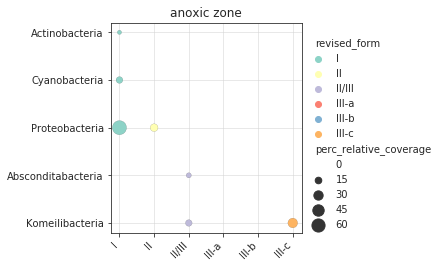

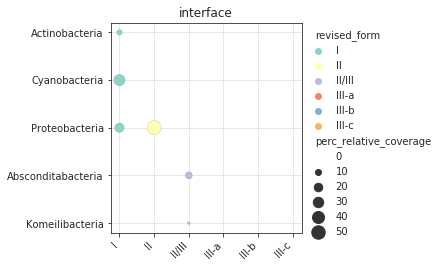

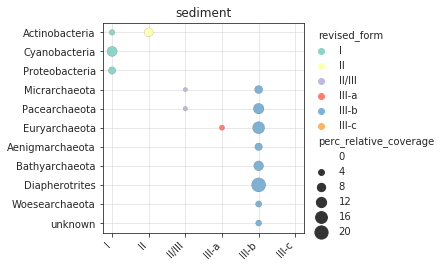

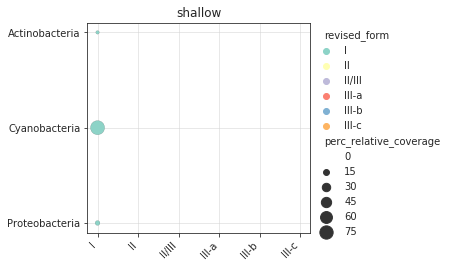

In [52]:
for compartment in merged_mean["compartment"].unique():

    if compartment != "blah":
        
        raw_table = merged_mean[merged_mean["compartment"]==compartment]

        # first, filter out taxa with no fields >= 1%
        maxs = raw_table.groupby("revised_taxonomy", as_index=False).aggregate({"perc_relative_coverage":"max"})
        to_drop = maxs[maxs["perc_relative_coverage"]<=1]["revised_taxonomy"].to_list()
        filt_table = raw_table[~raw_table["revised_taxonomy"].isin(to_drop)]

        # fill out all metabolisms in each table
        dummies = defaultdict(list)

        for key, row in merged_mean.drop_duplicates("revised_form").iterrows():

            if row["revised_form"] not in list(filt_table["revised_form"].unique()):

                dummies["compartment"].append(compartment)
                # choose random phylum
                dummies["revised_taxonomy"].append(filt_table["revised_taxonomy"].unique()[0])
                for field in ["revised_form"]:
                    dummies[field].append(row[field])
                dummies["perc_relative_coverage"].append(0)

        mod_table = pd.concat([filt_table, pd.DataFrame(dummies)])

        # plot
        sns.set_style("ticks")
        kws = dict(linewidth=.1, edgecolor="black")
        g = sns.relplot(x="revised_form", y="revised_taxonomy", 
            data=mod_table.sort_values(["revised_form"]), hue="revised_form",
            palette="Set3", size="perc_relative_coverage", sizes=(0,200),height=3.5,
            aspect=1.4,alpha=1, **kws, legend="brief")

        # add in lines
        for i in range(0, len(mod_table["revised_taxonomy"].unique())):
            plt.axhline(i, color='lightgrey', linestyle='-', lw=0.5,zorder=0)
        for i in range(0, len(mod_table["revised_form"].unique())):
            plt.axvline(i, color='lightgrey', linestyle='-', lw=0.5,zorder=0)

        plt.xticks(rotation=45, ha="right")
        plt.xlabel("")
        plt.ylabel("")
        plt.title(compartment)
        sns.despine(top=False, right=False)
        plt.savefig(rootdir + "figures/" + compartment.replace(" ","_") + ".svg", format="svg")
        plt.show()

### export

In [55]:
metadata.fillna("None").to_csv(rootdir + "tables/rubisco_metadata.tsv", sep="\t", index=False)

In [53]:
import re 

def revert_name(run):
    
    base = run.split("_")[1].split(".")[0]
    year = re.search("R([0-9]+)(.+)", base).group(1)
    sample = re.search("R([0-9]+)(.+)", base).group(2)
    return "LacPavin_%s_%s" %(year, sample)

In [54]:
merged["sample"] = merged["Sample"].apply(revert_name)
merged["compartment"] = merged["Sample"].apply(categorize)
supp_table = merged[["compartment", "sample", "Contig", "Covered Fraction", "perc_relative_coverage", "revised_form", "revised_taxonomy"]].sort_values(["compartment", "sample", "perc_relative_coverage"], ascending=[False,False,False])
supp_table.to_csv(rootdir + "tables/rubisco_supp.tsv", sep="\t", index=False)